## Imports 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
os.chdir('../src')          #All the modules are present in the src/ folder

In [4]:
from datetime import datetime

In [5]:
import model_building_utils as mb

# Step 0: Set Session variables

* **Description**: Creates a session object to track session level variables that do not have to be repeated and sets up the default model building configuration as well as logging of outputs

* **Inputs**: 
    * session_name: str, optional
        * Session name to be used for tracking in MLFlow or logs, otherwise default will be constructed from username and  timestamp
        
* **Outputs**:
    * curr_session: ModelBuildingSession
        * Session object loaded with the default model building configuration
        

### Input Choice Tips

* **session_name** : Pick a name that combines the key elements(region, train interval, runday)

In [6]:
session_name = None #set the session name

In [7]:
user_name = 'user'
session_name = 'trial'

#### Create a directory in the local path for storing outputs

In [8]:
if session_name is None:
    current_date = datetime.now().date().strftime('%-m/%-d/%y')
    session_name = user_name + current_date

# Directory to store the outptus from the current session
dir_name = session_name + '_outputs'

# Check if the directory exists
# if yes, raise a warning; else create a new directory
path_prefix = '../notebooks'
output_dir = os.path.join(path_prefix, dir_name)
if os.path.isdir(output_dir):
    print(f"{output_dir} already exists. Your logs might get overwritten.")
    print("Please change the session name to retain previous logs")
else:
    os.mkdir(output_dir)

../notebooks/trial_outputs already exists. Your logs might get overwritten.
Please change the session name to retain previous logs


In [9]:
current_session = mb.ModelBuildingSession(session_name)
current_session.set_param('output_dir', dir_name)
current_session.print_parameters()

experiment_name : SEIHRD_ENSEMBLE_V0
data_filepath : None
train_loss_function_config.C_weight : 0.25
train_loss_function_config.A_weight : 0.25
train_loss_function_config.R_weight : 0.25
train_loss_function_config.D_weight : 0.25
time_interval_config.train_start_date : 2020-07-20
time_interval_config.train_end_date : 2020-07-20
time_interval_config.backtesting_split_date : 2020-07-20
time_interval_config.forecast_start_date : 2020-07-20
time_interval_config.forecast_end_date : 2020-07-20
time_interval_config.forecast_planning_date : 2020-07-20
output_dir : trial_outputs


# Step 1: View Past Forecasts

* **Description**: Returns links to previously generated forecasts for the specified region

* **Inputs**: 
   * region_type: REGION_TYPE
       * valid region type from ['country','state','district','other']
   * region_name: REGION_NAME
       * valid region name
   * experiment_name: EXPERIMENT_NAME
       * valid experiment name (default: SEIHRD_ENSEMBLE_V0)
   * interval_to_consider: int, optional
       * number of past days to consider for retrieving runs (default =0)
       
* **Outputs**:
    * run_links: list[URL]
        * list of URLs corresponding to relevant "published" ML-Flow links (for now returns a pandas df containing links)

### Input Choice Tips

* **region_type**: 'other' can be used for smaller regions or stratification by some groups (e.g., slums in a region) along with 'csv' source
* **region_name**: Please make sure the spelling and the case of the region_name is correct. Here is a list <TODO:ADDLinks> of valid regions.
* **interval_to_consider**: It is useful to look at the data trends/model parameters from at least one  earlier forecast and contrast that with the current one. 

In [10]:
current_session.set_param('region_name', 'mumbai')
current_session.set_param('region_type', 'district')
current_session.set_param('experiment_name', 'SEIHRD_ENSEMBLE_V0')

In [11]:
current_session.view_forecasts()

,Published on,Run name,Link to run


# Step 2: Examine Data

* **Description**: Obtains case count data for specified region and displays it 
    as a table and a plot, and writes out the plot as specified 

* **Inputs**: 
    * region_type: REGION_TYPE
        * valid region type from ['country','state','district']
    * region_name: REGION_NAME
        * valid region name
    * data_source_type: DATA_SOURCE_TYPE
        * valid source type from ['official','tracker','csv']
    * data_filepath: str, optional
        * valid local file path of csv file to be uploaded, required only for 'csv' source  
    * case_cnt_plot_file_name: str, optional
        * file_path where the plot file will be written (default ="case_cnt_data_observed.png")
    * case_cnt_csv_file_name: str, optional
        * file_path for output of a standard csv with date and CARD variables (default ="case_cnt_data.csv")
        
* **Outputs**:
    * case_cnt_data: pandas.DataFrame
        * dataframe in a standard format with date and CARD variables

### Input Choice Tips

* There is no need to set parameters that are already set (e.g., region_name) 
* It is preferable to allow output artifact filepaths (e.g., case_cnt_plot_file_name) to also remain as defaults unless there is specific requirement
* **data_filepath**  needs to be set only when the source is csv. 
* Sanity checking has to be done externally for now

## Using data from a file

### Format requirements for csv input


Expected columns in the csv

**date, confirmed, active, recovered, deceased**

In [20]:
current_session.set_param('region_type', 'state')
current_session.set_param('region_name', 'delhi')
current_session.set_param('data_source', 'direct_csv')

#Specify an appropriate path depending on your system
current_session.set_param('data_filepath', '/Users/shreyas.shetty/delhi_case_cnt.csv')

current_session.set_param('case_cnt_plot_file_name', 'case_cnt_plot_delhi.png')
current_session.set_param('case_cnt_csv_file_name', 'case_cnt_delhi.csv')

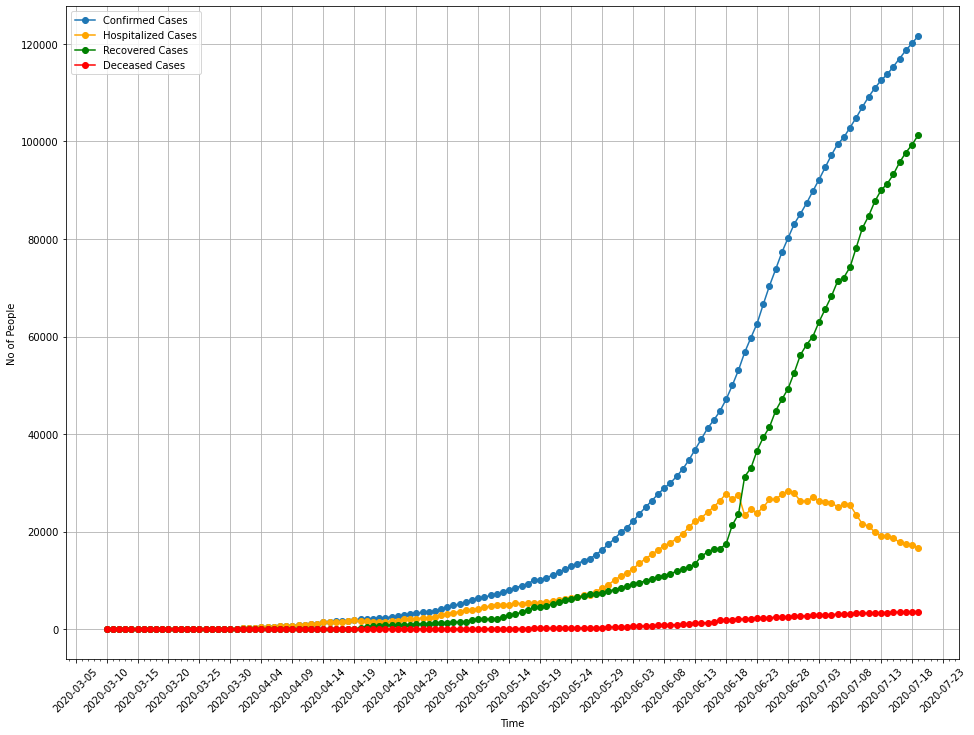

In [21]:
current_session.examine_data()

## Using rootnet data

In [22]:
current_session.set_param('region_type', 'state')
current_session.set_param('region_name', 'delhi')
current_session.set_param('data_source', 'rootnet_stats_history')

current_session.set_param('case_cnt_plot_file_name', 'case_cnt_plot_delhi.png')
current_session.set_param('case_cnt_csv_file_name', 'case_cnt_delhi.csv')

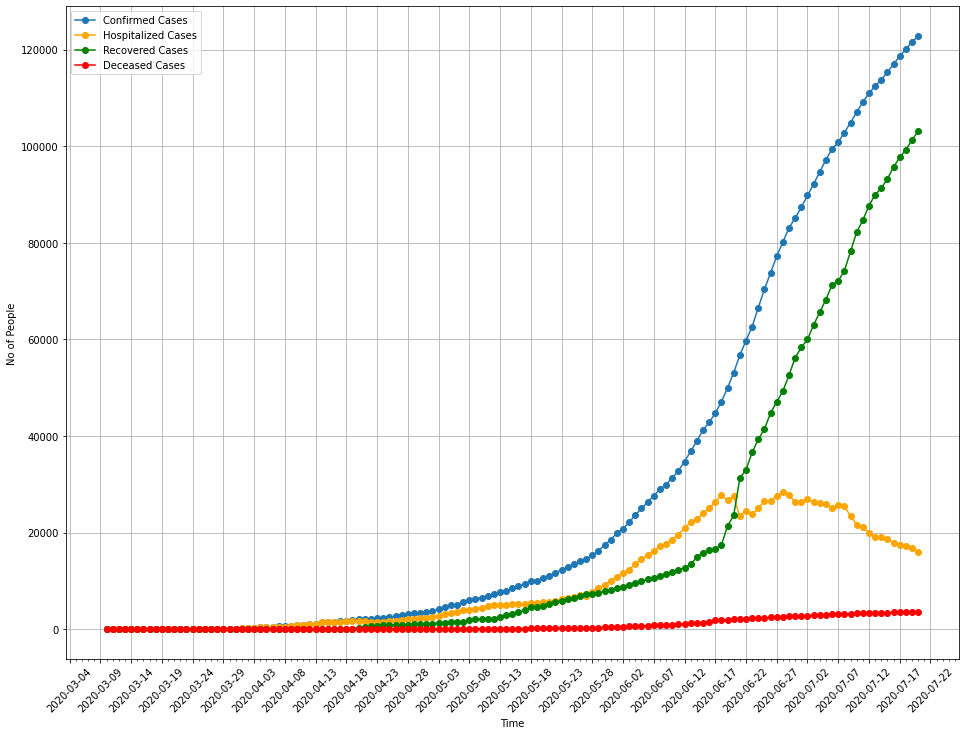

In [23]:
current_session.examine_data()

# Step 3: Build Models  & Generate Forecasts

* **Description**: Build models as per the specified configuration, generate train, evaluation reports and also forecasts

* **Inputs**: 
    * region_type: REGION_TYPE
        * valid region type from ['country','state','district']
    * region_name: REGION_NAME
        * valid region name
    * data_source_type: DATA_SOURCE_TYPE
        * valid source type from ['official','tracker','csv']
    * data_filepath: str
        * valid local file path of csv file to be uploaded
    * time_interval_config: TrainTestForecastDatesConfig
        * dates to be used for training, evaluation and forecast
        * see <TODO:add links> for more details (default =mb.TRAIN_TEST_FORECAST_CONFIG)
    * model_class: MODEL_CLASS, optional
        * valid model class in mb.MODEL_CLASS (default ='SEIHRD')
    * num_trials: int, optional
        * number of trials to be used for training (default ='1000')
    * param_searchspace_config: ParamSearchSpaceConfig, optional
        * search space limits, default values and fine-tunability of various configurations
        * see <TODO:add links> for more details (default =mb.PARAM_SEARCHSPACE_CONFIG)
    * train_loss_function_config: LossFunctionConfig, optional
        * relative weighting of CARD variables & loss metric to be used for training
        * see <TODO:add links> for more details (default =mb.TRAIN_LOSS_FUNCTION_CONFIG)
    * eval_loss_function_config: list[LossFunctionConfig], optional
        * all the loss functions required for evaluation
        * see <TODO:add links> for more details (default =mb.EVAL_LOSS_FUNCTION_CONFIG)       
    * forecast_percentiles: list[float], optional
        * list of percentiles that need to be forecast    
    * detailed_report_file: str, optional
        * filepath for the detailed report of the model building run
    * summary_report_file: str, optional
        * filepath for the summary report of the model building run
    * planning_input_report_file: str, optional
        * filepath for the report that contains inputs needed for the planning step 
    
* **Outputs**:
    * model_building_params: dict
        * flattened dict of input configuration used for the model building run
    * model_building_metrics: dict
        * flattened dict of output metrics from the model building run
    * model_building_artifact_list: list[str]
        * list of artifact files (e.g., jsons, plots, csvs, reports) generated

### Input Choice Tips
* As before, there should really be no need to set parameters that are already set even though they are presented again
* There is also no need to change the output artifact filepaths
* This step **does not have*** any mandatory inputs.  
* **Typical User Setup**: 
    * **Relative weights of the variables:**
        * If all the variables C, A, R, D are reliable and equally important for forecast accuracy, then we would wish to give equal weightage  to all of them. 
        * Note that, C, R and D are the independently observed variables and A is derived as A = C-R-D.  Skipping any one of the variables will still provide the same fits.
        * Depending on the application or the modeling purpose, a certain variable, e.g., active cases (A) might be more important than the others and a higher relative weight would be appropriate in that case
        * If any of the independent variables (e.g., recoveries R) is not reliable because of spikes or unlikely values, then it is preferable to just fit to the two other independent variables or at least adjust the relative weights accordingly
    * **Forecast planning variable:**
        * This is the variable that is primarily used for forecast planning and uncertainty estimation (default is Active case count A).
    * **Dates for training, evaluation and forecasting:**
        * **train_end_date**: chosen to be the latest date for which reliable data is available (default choice is d = previous day)
        * **train_start_date**: chosen to be the earliest date since which observations can be used for the current analysis (default choice is  d-14 ). Due to govt policy and public behavior changes, the dynamics themselves are continuously evolving and it is preferable to keep this window small, but at the same adequate to estimate the model parameters in a relatively robust way. 
         * **backtesting_split_date**: chosen to be the date (default choice is d-7) that can be used to split the train period into two intervals, where the first interval is used for training the model that can be used for evaluation on the later interval. The later interval is then used to retrain the model used for forecasting. This process is described in more detail in Model Building Methodology<TODO:AddLinks>. 
         * **forecast_start_date**: chosen to be the date starting from which we need the forecast (default choice is the d'= next day)
         * **forecast_end_date**: chosen to be the date till which we need the forecast (default choice is d'+30)
         * **forecast_planning _date**: chosen to be the date to be used for medical planning and percentile calculations (default choice is the d'+15) 

* **Expert User Setup**: 
    * If required, experts familiar with epidemiological parameters can also play around with the default model parameters and training search space. All the model building parameters, default values and the relevant information for finetuning these are listed in ModelBuildingParameters <TODO:ADDLinks>

In [24]:
current_session.set_param('model_class', 'homogeneous_ensemble')

100%|██████████| 10/10 [00:00<00:00, 44.70trial/s, best loss: 102.01490471079998]
Best fit: {'beta': 0.7846092101028024}
Best Loss: 102.01490471079998
t = 15.90
t = 15.90
100%|██████████| 10/10 [00:00<00:00, 48.12trial/s, best loss: 7.874592459616524]
Best fit: {'beta': 3.61833518725152}
Best Loss: 7.874592459616524


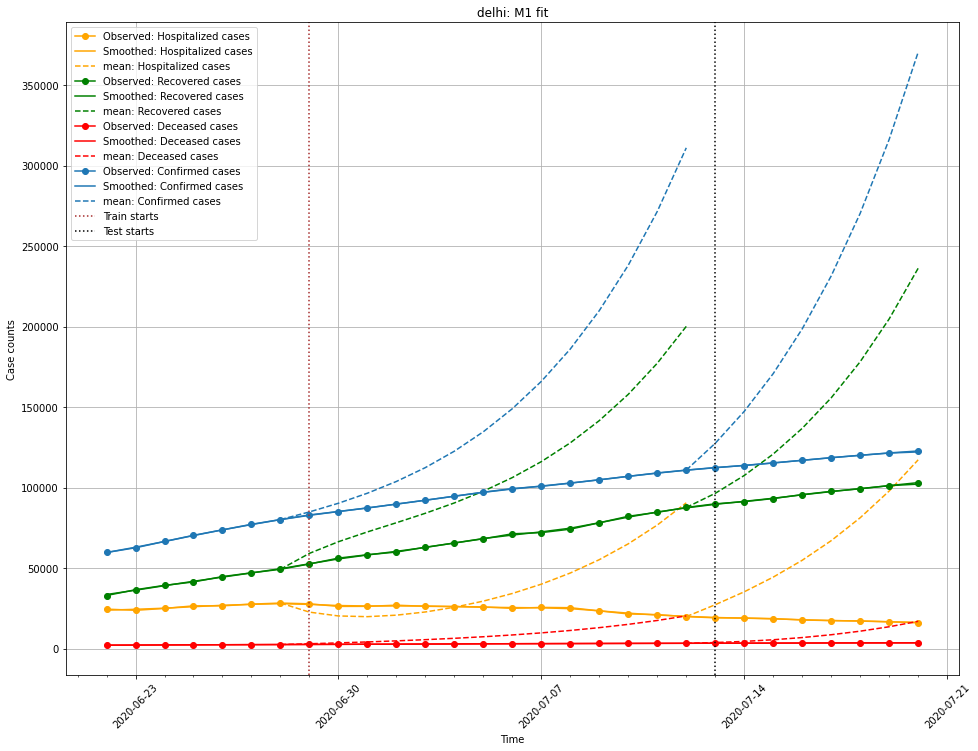

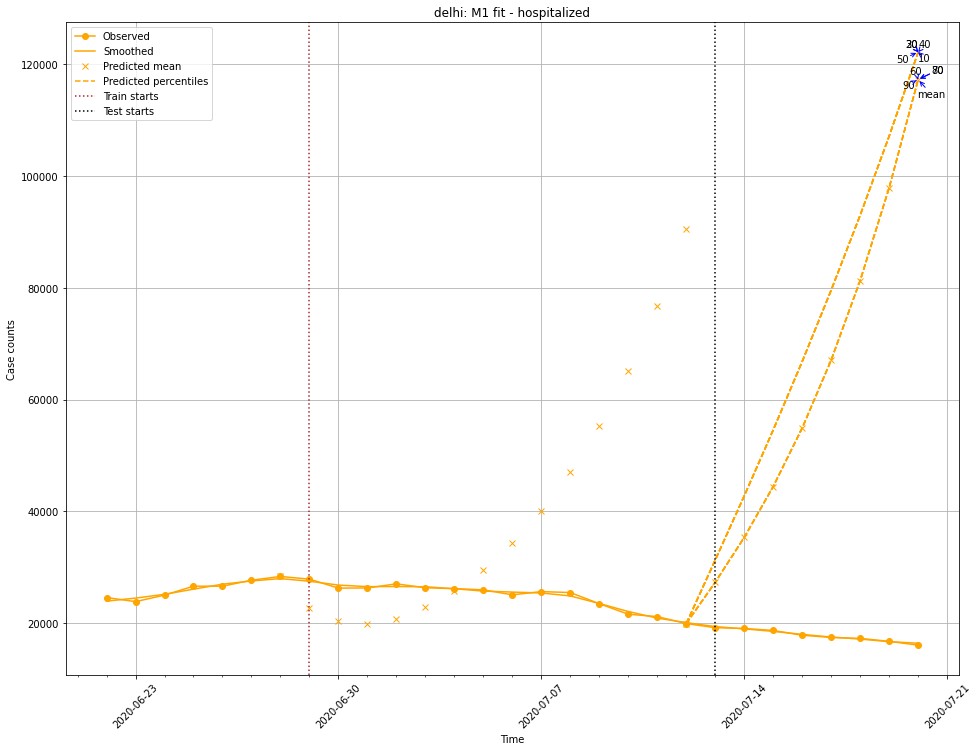

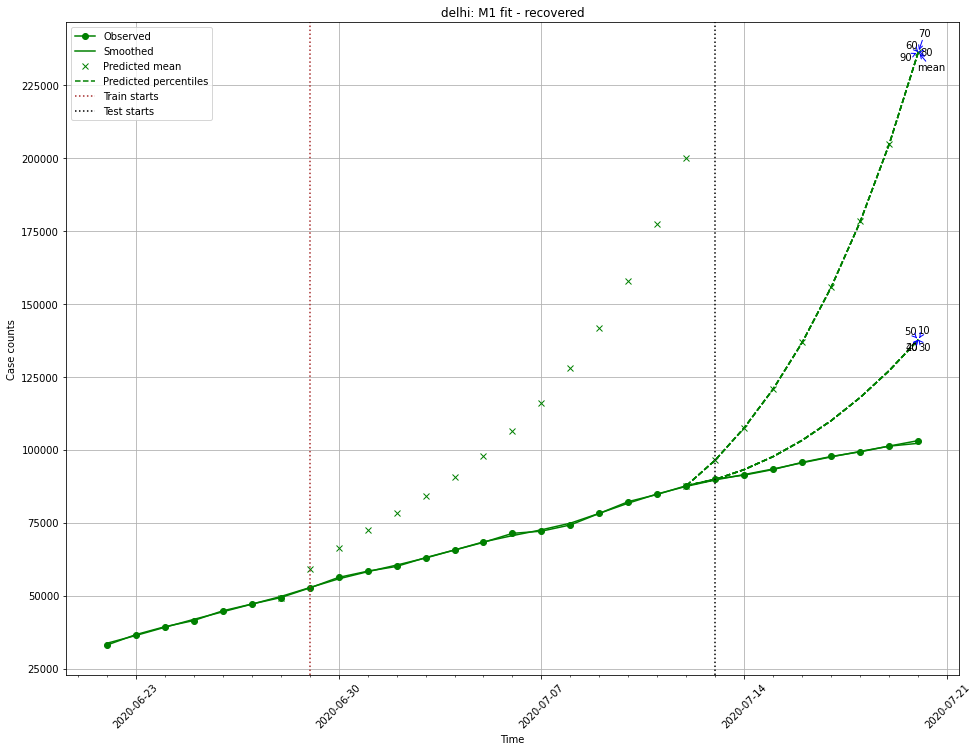

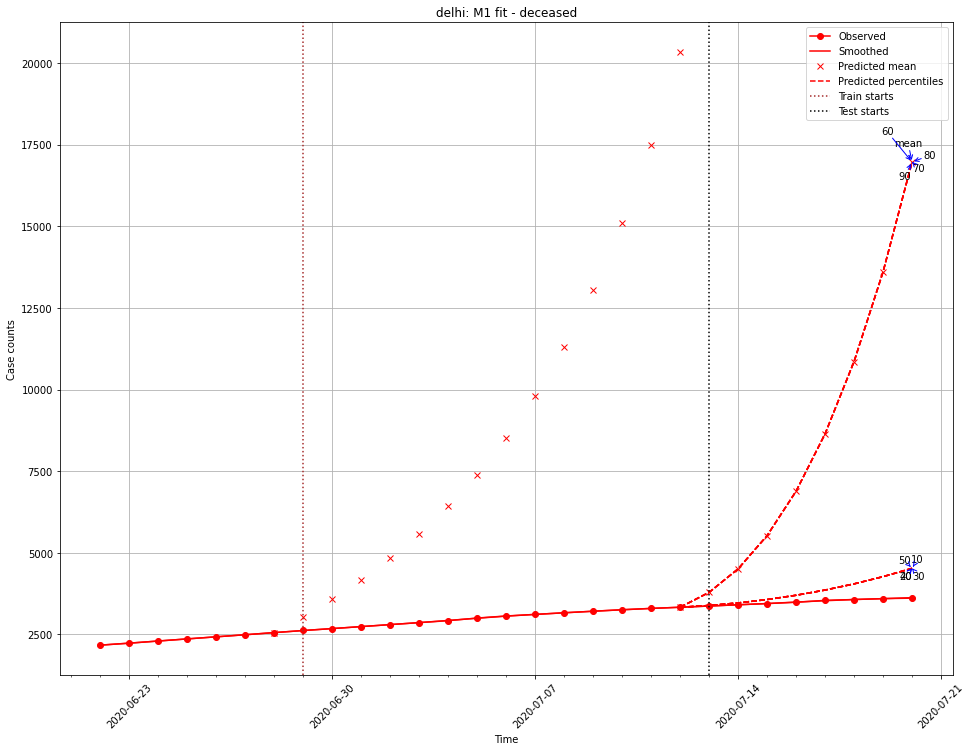

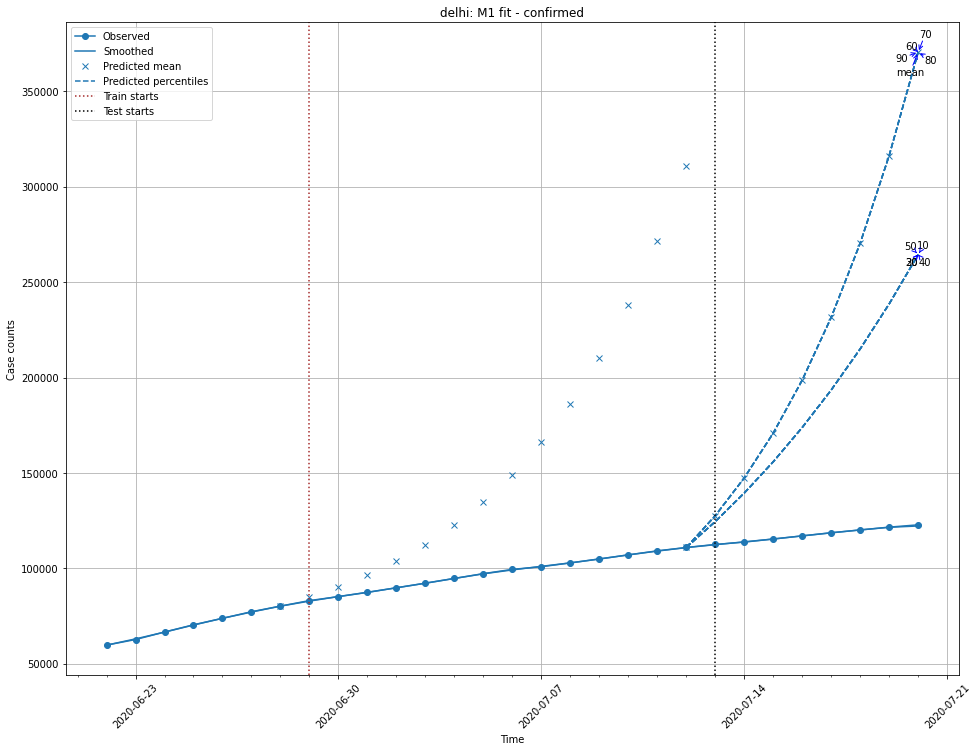

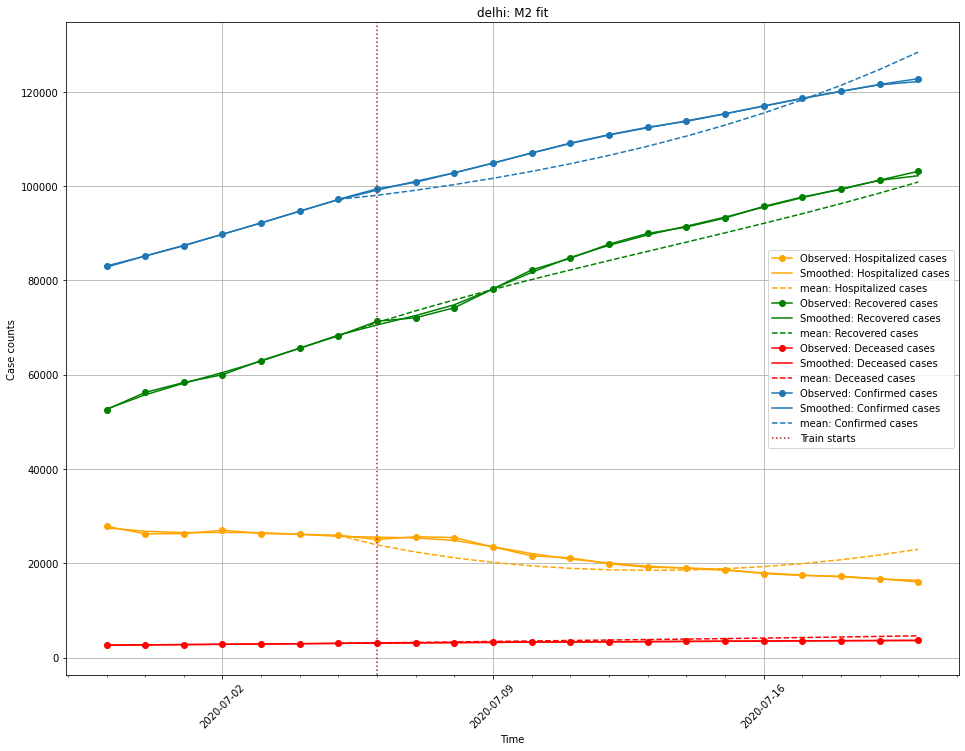

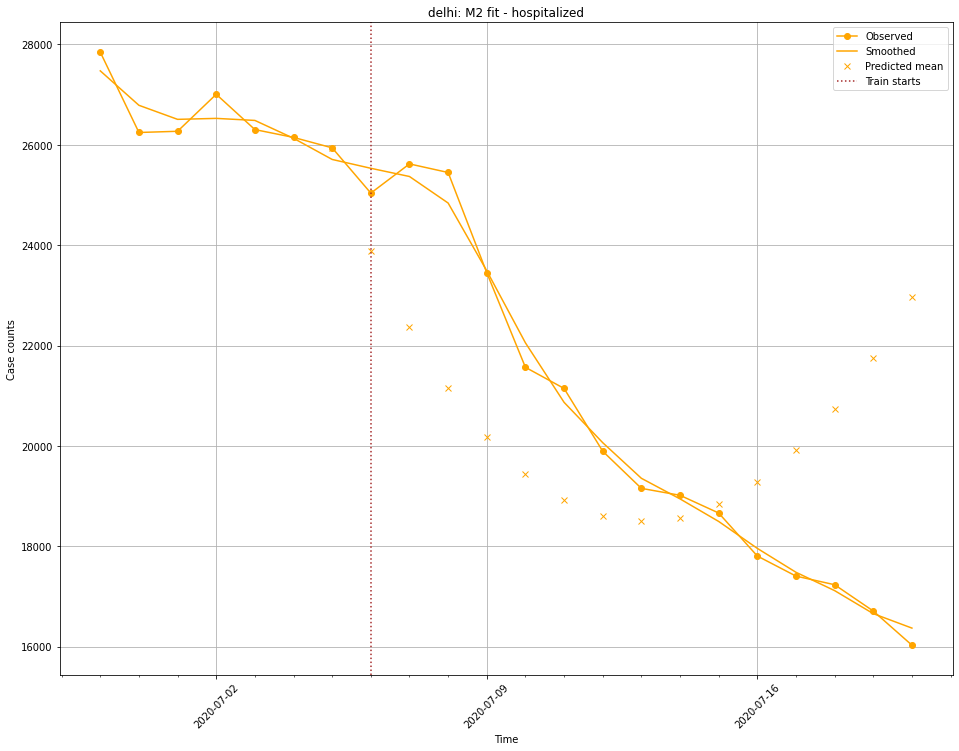

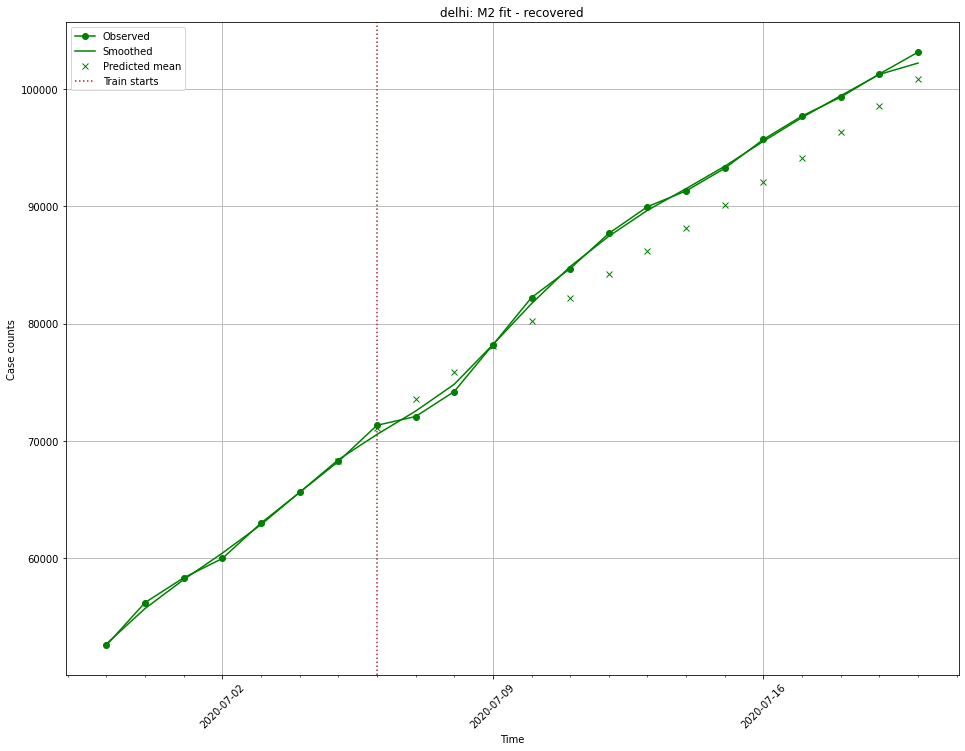

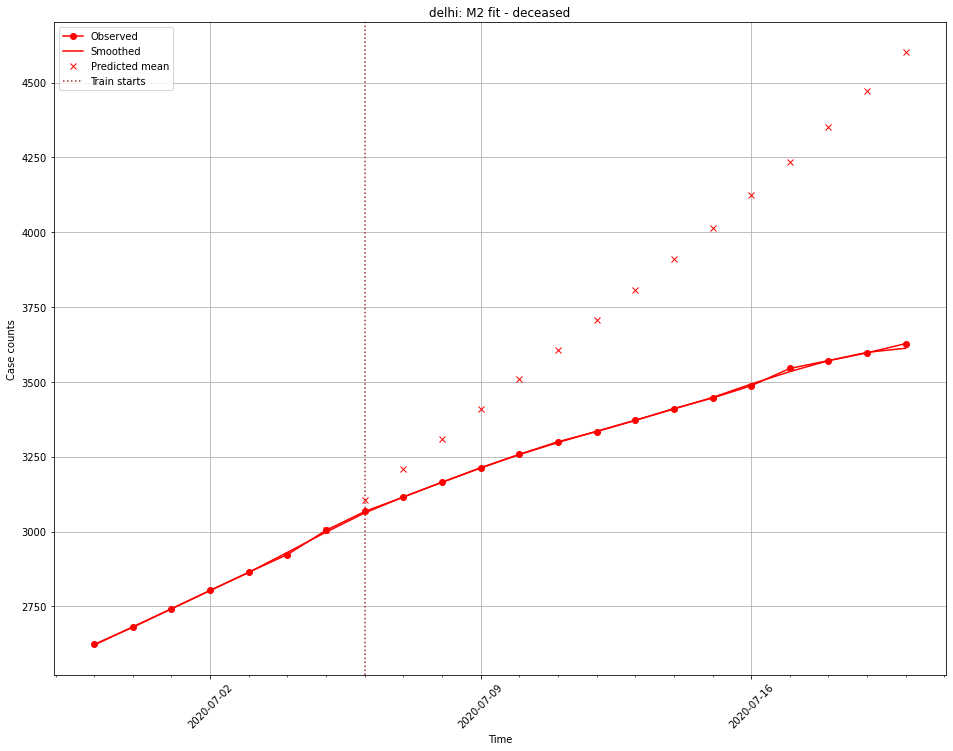

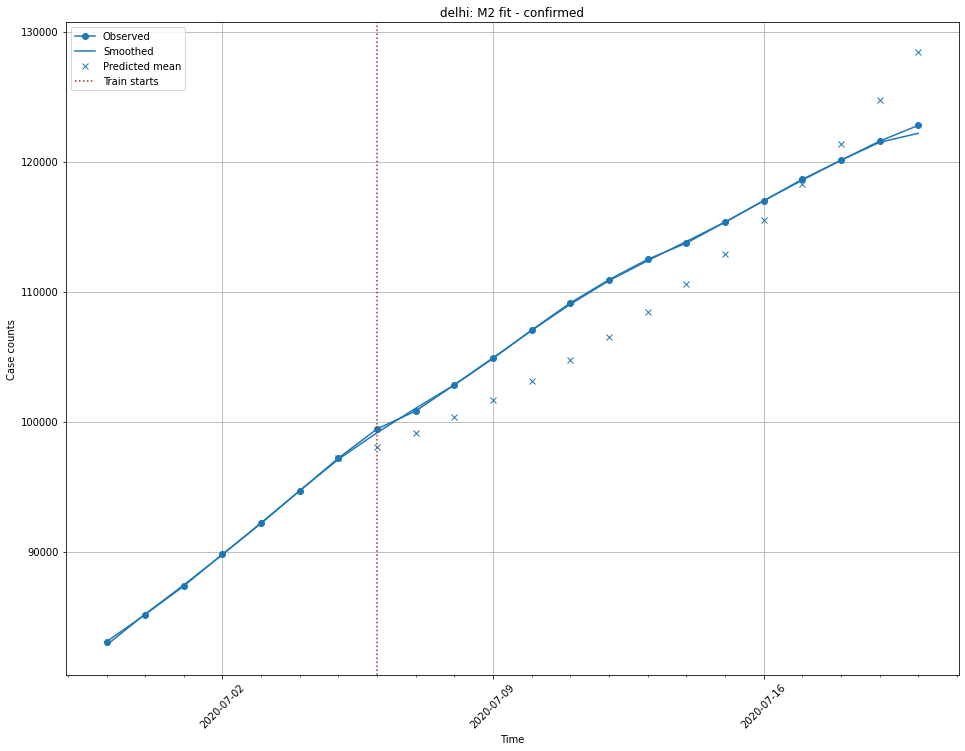

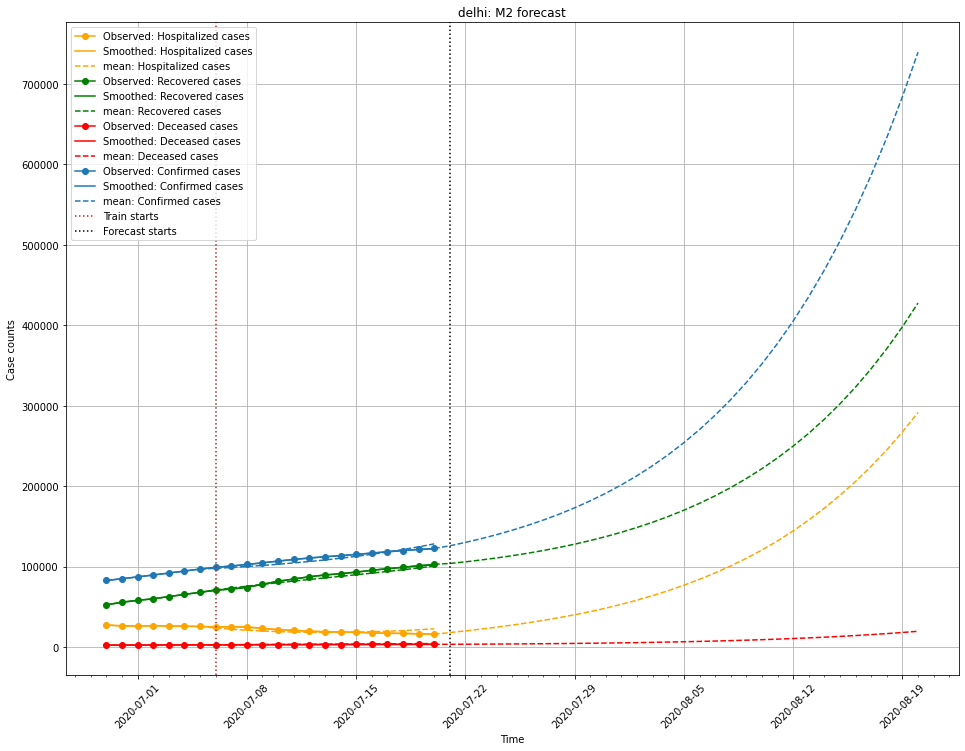

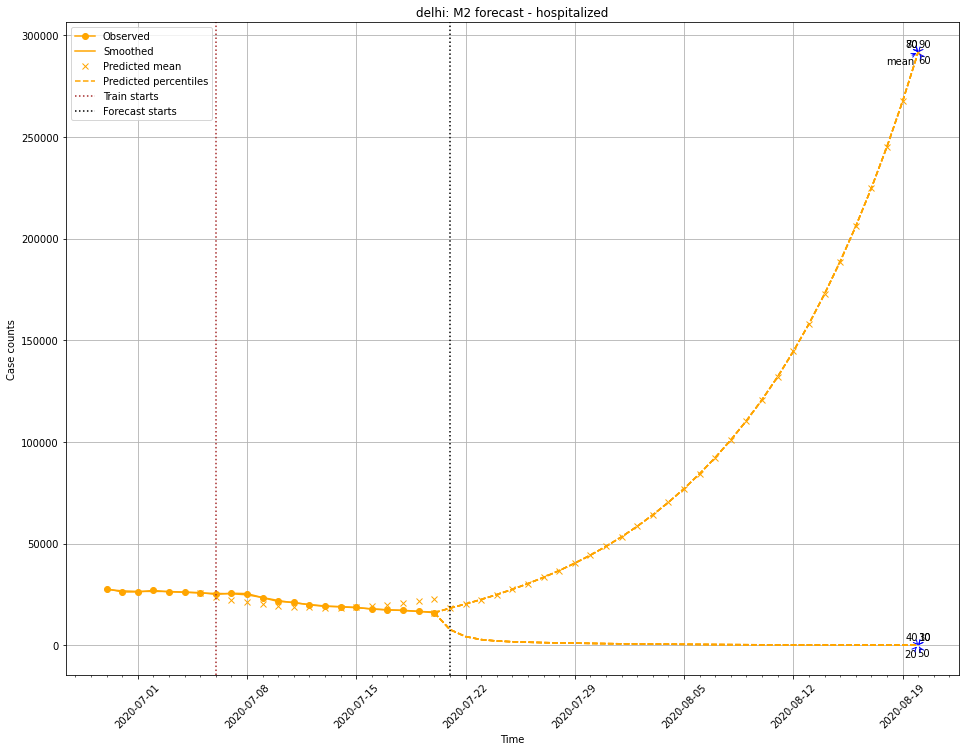

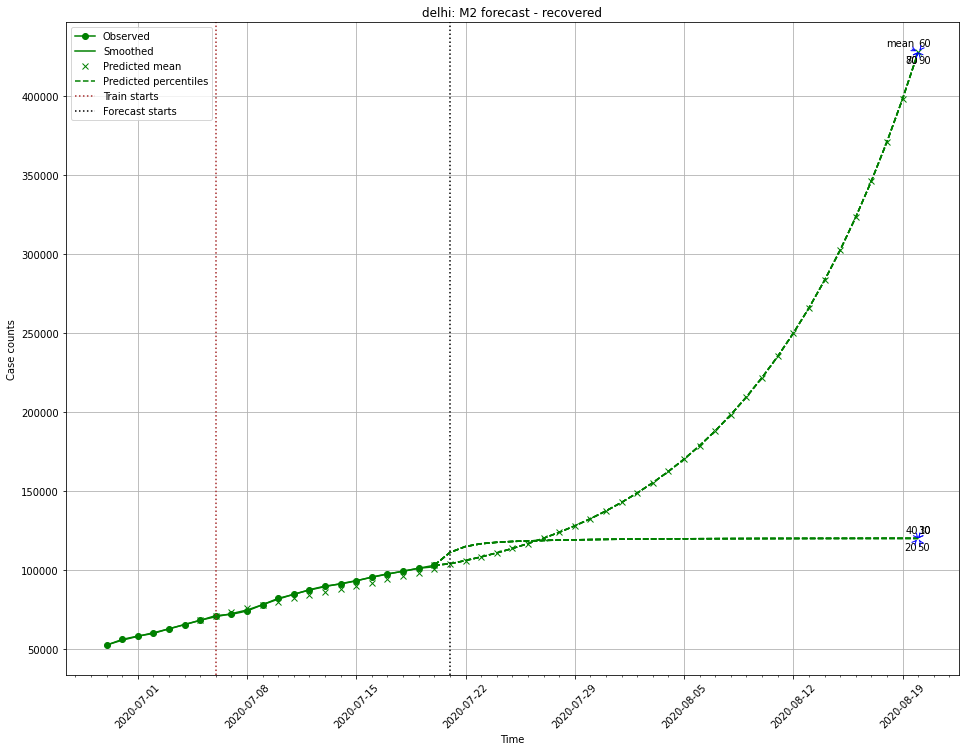

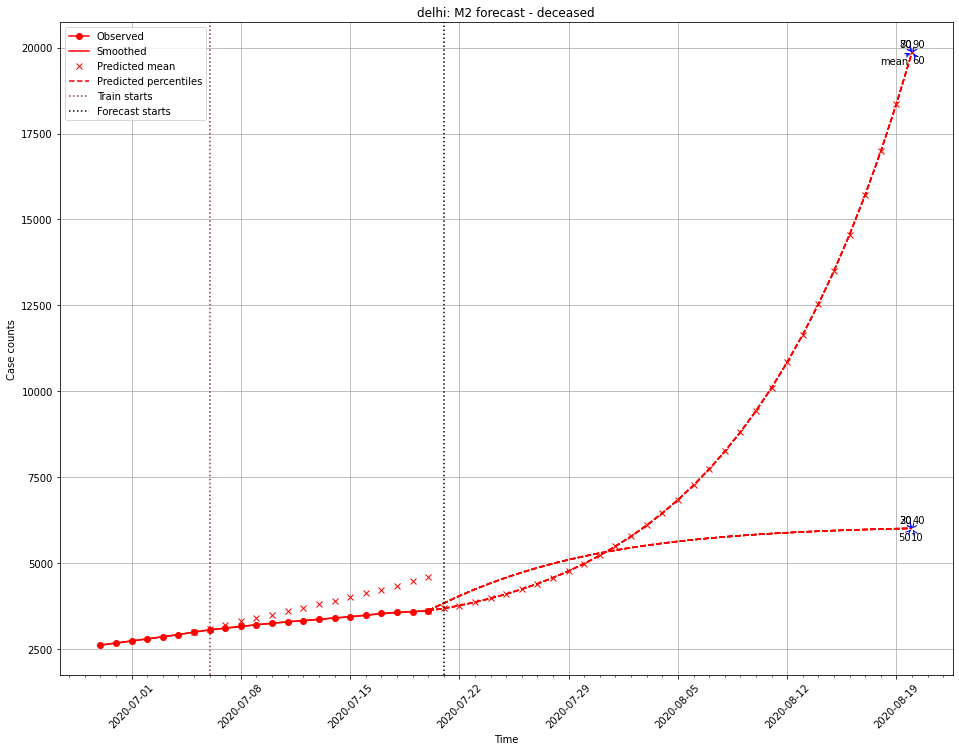

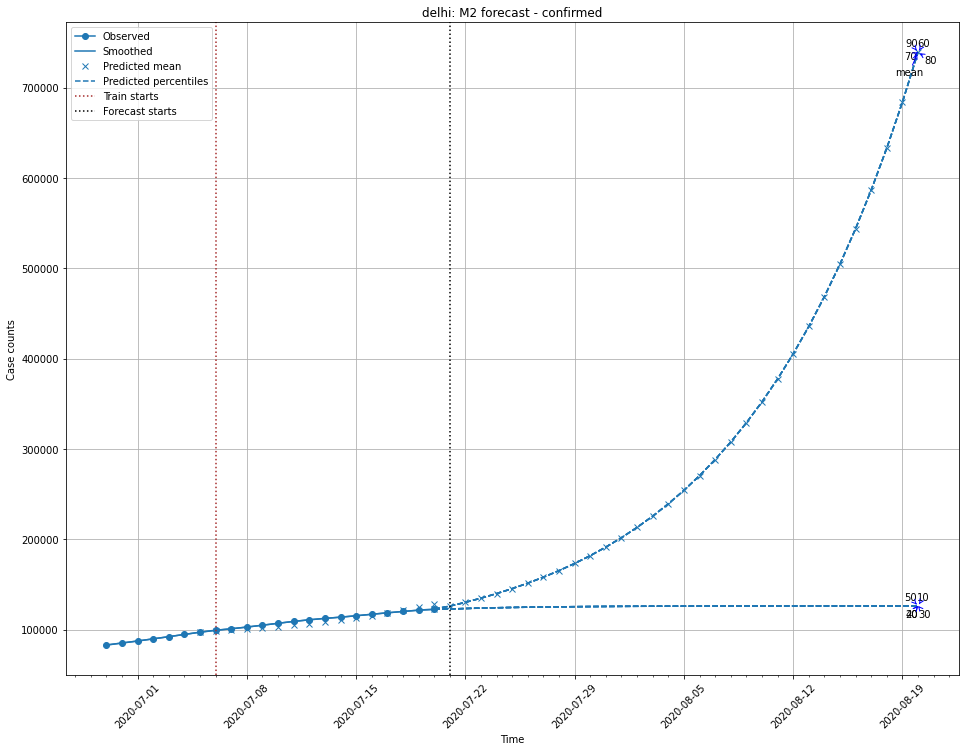

In [25]:
current_session.build_models_and_generate_forecast()